# Recitation 7: more systems simulation

* Simulation of a web app

# More simpy systems simulation

Consider a web app, e.g. an online navigation service, or AirBnB, or Facebook, or whatever.

When a user goes to the site, their browser makes API requests using a request-response style to the backend servers. E.g. when you click "Book" on AirBnB, a request is sent to the AirBnB servers to make some changes in their databases.

(Lately, a architecture called "microservices" has been very common, where each user request is split up into smaller sub-requests that are sent off to sub-services, and so each request might result in tens or even hundreds of jobs/requests.)

Naturally, there's a lot of randomness.

Suppose you run AwesomeWebApp, and customers use the app "randomly". A good first model for this is to say that request to the app come from users according to a Poisson process.

AwesomeWebApp is a tool that allows users to store their favourite recipes.

Each time an "add new ingredient" request arrives at the backend server. You have to do the following things:

1. Get the user's details from the database. (E.g. do an SQL query like `select * from users where user_id = xxx`.) [mean 2 ms]
2. Get the user's recipe book by ID [10 ms]
3. Add the ingredient to the user's recipe book [25 ms]
4. Generate a response [5 ms]

BUT! There are constraints. The database can only do up to 20 connections at a time. Assume service times are Pareto distributed with given means. Or whatever `funky_dist` actually is...

Questions we want to ask:

1. How many concurrent users can we support? In particular, how many QPS (queries per second).

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def funky_dist(mean_ms, **kwargs):
    return mean_ms / 1000 * np.random.pareto(2, **kwargs)

In [3]:
p99s = []

for db_cap in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    last = 0
    i = 0

    # i-th element tells amount of time with i customers
    histogram = np.zeros(0)

    wait_times = []

    def update_hist(env, new_i):
        global last, i, histogram
        if len(histogram) <= i:
            histogram.resize(i+1)
        histogram[i] += env.now - last
        last = env.now
        i = new_i

    def requests(env, db_connection, qps):
        req_id = 0
        while True:
            req_id += 1
            inter_arrival_time = np.random.exponential(1/qps)
            yield env.timeout(inter_arrival_time)
            env.process(add_new_ingredient(env, db_connection, req_id))

    def do_db_query(env, db_connection, mean_duration_ms):
        # note that mean duration is specified in milliseconds (1e-3 s)
        req = db_connection.request()
        yield req
        yield env.timeout(funky_dist(mean_duration_ms))
        db_connection.release(req)

    def add_new_ingredient(env, db_connection, req_id):
        global i
        start = env.now
        update_hist(env, i + 1)
    #     print(f"{env.now:5.2f}: starting request id {req_id}")
        # 1: get user details
        yield from do_db_query(env, db_connection, 2)
        # 2: get their recipes
        yield from do_db_query(env, db_connection, 10)
        # 3: add an ingredient to the recipe
        yield from do_db_query(env, db_connection, 25)
        # 4: generate the response object (e.g. format stuff nicely, etc)
        yield env.timeout(funky_dist(5))
        update_hist(env, i - 1)
    #     print(f"{env.now:5.2f}: finished request id {req_id}")
        end = env.now
        wait_times.append(end - start)

    # simulation time will be in seconds!
    env = simpy.Environment()
    db_connection = simpy.Resource(env, capacity=db_cap)
    env.process(requests(env, db_connection, 100))
    env.run(until=300)
    wait_times = np.array(wait_times)
    p99 = np.quantile(wait_times, .99)
    print(f"p99 for {db_cap=} is {p99}")
    p99s.append(p99)

p99 for db_cap=2 is 152.80411238360932
p99 for db_cap=3 is 63.810460661871474
p99 for db_cap=4 is 1.078973405114055
p99 for db_cap=5 is 0.6044203975079503
p99 for db_cap=6 is 0.2808355836716346
p99 for db_cap=7 is 0.2920563495303662
p99 for db_cap=8 is 0.2786980220295494
p99 for db_cap=9 is 0.27275108820534977
p99 for db_cap=10 is 0.26363520440919874


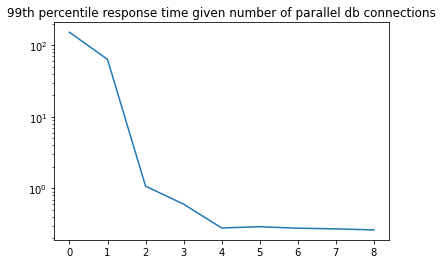

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(p99s)), p99s)
ax.set_yscale("log")
plt.title("99th percentile response time given number of parallel db connections");

In [5]:
wait_times = np.array(wait_times)
p99 = np.quantile(wait_times, .99)

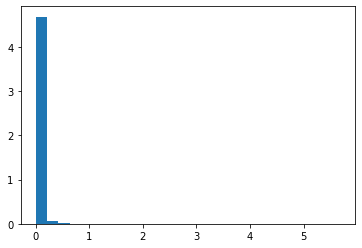

In [6]:
plt.hist(wait_times, density=True, bins=27);

Text(0.5, 1.0, 'Response times for all but top 1% requests')

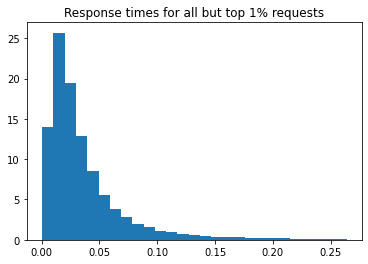

In [7]:
plt.hist(wait_times[wait_times < p99], density=True, bins=27);
plt.title("Response times for all but top 1% requests")

In [8]:
np.quantile(np.array(wait_times), .99)

0.26363520440919874

<BarContainer object of 18 artists>

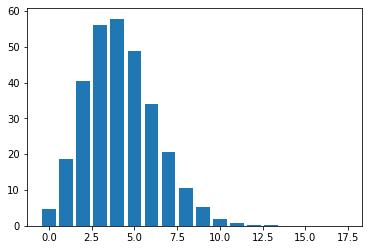

In [9]:
plt.bar(np.arange(len(histogram)), histogram)

In [10]:
# 99th percentile of customers in system
np.quantile(histogram, .99)

57.54030283412198

In [11]:
histogram.sum()

299.99509505551646